<a href="https://colab.research.google.com/github/mohammedterryjack/question_generation/blob/main/QuestionGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Question Generation

In [37]:
from typing import List, Tuple, Optional

# 1. Baseline (Heuristic)

**Description**:

Our baseline method (to compare all future approaches against) is a very simple heuristic which randomly chooses a seed token from a predefined list of words typically found at the beginning of generic questions


In [19]:
from random import choice

seed_tokens = ["can","what","when","why"]
seed_question = choice(seed_tokens)
seed_question

'why'

The keywords are then extracted from the utterances using a simple `stopword` filter (We use `NLTK` for its inbuilt stopword list)


In [21]:
from nltk import download
download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords

stopword_tokens = set(stopwords.words('english'))

def extract_keywords(text:str) -> List[str]:
    return list(filter(lambda token:token not in stopword_tokens, text.split()))

keywords = extract_keywords("this is an example")
keywords

['example']

A couple of keywords are randomly sampled and appended to the seed question to ensure it has some superficial level of coherence 


In [24]:
from random import sample

number_of_samples = min(len(keywords),2)
seed_question += f" {' '.join(sample(keywords,number_of_samples))}"
seed_question

'why example'

This can sound unnatural and so the final step is to translate the question into another language (e.g. arabic) and back into english to encourage more natural phrasing (We use `Textblob`'s inbuilt translate function).


In [18]:
download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
from textblob import TextBlob
from textblob.exceptions import NotTranslated

def rephrase_for_fluency(text:str) -> str:
    analysis = TextBlob(text)
    try:
        return ' '.join(analysis.translate(to='ar').translate(to='en').words) + "?"
    except NotTranslated:
        return text


This method is known as `spinning` and can modify words (e.g. like -> love)


In [20]:
rephrase_for_fluency("i like cats")

'I love cats?'

In [17]:
def quick_generate(text:str) -> str:
  question = extract_seed_question(text)
  return rephrase_for_fluency(question) 

def extract_seed_question(text:str) -> str:
  seed_question = choice(seed_tokens)
  keywords = extract_keywords(text)
  if any(keywords):
    number_of_samples = min(len(keywords),2)
    seed_question += f" {' '.join(sample(keywords,number_of_samples))}"
  seed_question += " ?"
  return seed_question

In [22]:
quick_generate("i like cats")

'What do cats like?'

**Pros**:

- The baseline method does not require any training to begin using 
- it is a lightweight solution

**Cons**:

- Although spinning produces a natural sounding question, it does not ensure that the final question makes sense nor that it sounds intelligent (e.g. "Can you love cats?" is a strange question to ask).  
- This method will not introduce any semantic novelty into the question (the meaning of the question will be nearly identical to the original utterances) thus creating a coherent yet dull question overall

In [29]:
while True:
  print(quick_generate(input(">")))

>this is a test
can you test?
>i live near a forest
Which forest do you live in?


KeyboardInterrupt: ignored

# 2. Albert Mask Token (Pre-trained)


The next method maintains the main advantage of the baseline (i.e. it does not need training) yet improves upon it by being able to generate words and, thus, add novelty into the semantics of the question.  To generate questions, we use a pre-trained instance of `Albert` (Albert stands for "A lite BERT") as it promises to have similar performance to `BERT` while being lighter.  

The reason we use Albert is to do with the tasks it was trained on.  Most pretrained Generative language models (e.g. `GPT3`, `GPT-Neo`, `T5`, Bert, etc) are able to generate text, but they are not specifically trained to generate questions.  Now Albert is no exception, however, unlike T5 and the GPT family, BERT (and Albert by extension) are trained on a specific task which does make it possible for us to generate questions without having to retrain of fine-tune it at all!  This is the Masked Token Prediction task, 

We can use Albert's ability to predict a masked token to trick it into inserting new words into a question, thus growing the sentence from within!  

e.g.
```python 
iteration 1:
	question: "what cats?"
	inserted mask: "what [MASK] cats?"
	predicted word: "what [cute] cats"

iteration 2:
	question: "what cute cats?"
	inserted mask: "what [MASK] cute cats?"
	predicted word: "what [are] cute cats?"

iteration 3:
	question: "what are cute cats?"
	inserted mask: "what are cute cats [MASK]?"
	...etc
```

This method of natural language generation via 'inserting' new words differs from most generation tasks (which involve predicting the next word or character at the end of a given sequence), but the reason we choose such a method is due to the convenience of constraining the generated text into a desired format (i.e. the form of a question) by specifying the initial and final tokens (e.g. "what ... ?"). 


First we construct the function which inserts the mask token somewhere inside the question

In [9]:
from random import choice

mask_token = "[MASK]"

def grow_question(question:str) -> str:
    tokens = question.split()
    index = choice(range(len(tokens)))
    new_tokens = tokens[:index] + [mask_token] + tokens[index:]
    return predict_masked_words(text=' '.join(new_tokens))

In order to predict the masked token, we need to load in the pretrained Albert model from Huggingface's `transformers` library and pass it the question containing the masked tokens


In [28]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 37.3 MB/s 
     |████████████████████████████████| 636 kB 33.8 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 895 kB 39.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [30]:
!pip install SentencePiece

     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [1]:
from transformers import AlbertTokenizer, AlbertForMaskedLM

model_name = 'albert-base-v2'

tokeniser = AlbertTokenizer.from_pretrained(model_name)
model = AlbertForMaskedLM.from_pretrained(model_name)


def predict_masked_words(text:str) -> str:
    inputs = tokeniser(text, return_tensors="pt")
    outputs = model(**inputs)
    
    tokens = tokeniser.convert_ids_to_tokens(inputs.input_ids[0])
    predicted_tokens = tokeniser.convert_ids_to_tokens(outputs.logits[0].argmax(dim=1))
    
    replaced_tokens = replace_mask_tokens_with_predicted_tokens(tokens,predicted_tokens)
    return format_albert_tokens_as_string(replaced_tokens)

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Replacing the masked token is simply a matter of finding the predicted token in the position of the masked token


In [11]:
def replace_mask_tokens_with_predicted_tokens(tokens:List[str],predictions:List[str]) -> List[str]:
	for index,token in enumerate(tokens):
		if token==mask_token:
			tokens[index] = predictions[index]
	return tokens


And the tokens (with the masks replaced with predictions) are then converted into a string - cutting off the special tokens added by albert's tokeniser to the start ("[CLS]") and end ("[SEP]")


In [7]:
def format_albert_tokens_as_string(tokens:List[str]) -> str:
    return ''.join(map(lambda token:token.replace("▁"," "), tokens[1:-1]))


In [13]:
predict_masked_words("i went to the [MASK] the other day")

' i went to the dentist the other day'

In [14]:
grow_question("why cats?")

' but why cats?'

We can repeat this process as many times as you like to grow the question iteratively


In [15]:
def generate(text:str, max_iterations:int=5) -> str:
	question = extract_seed_question(text)
	for iteration in range(max_iterations):
		question = grow_question(question)
	return question


In [26]:
generate(text="i like cats")

' what sounds like feral feral feral cats? ?'

In [33]:
def remove_tokens_for_fluency(text:str,tokens:List[str]) -> str:
  for token in tokens:
    text = text.replace(token,'')
  return text

ignored_albert_tokens = ["evalle","joyah"]

def generate(text:str, max_iterations:int=5) -> str:
  question = extract_seed_question(text)
  for iteration in range(max_iterations):
    question = grow_question(question)
  question = remove_tokens_for_fluency(question,ignored_albert_tokens)
  question = rephrase_for_fluency(question) 
  return question

In [35]:
generate(text="i like cats")

'When do I like to feed my cat stuffed?'

**Pros**:

- The model works off-the-shelf without needing to be retrained or fine-tuned 

- The generated questions add far more novelty and engagement than the baseline, while keeping it relevant (e.g. "Are you wondering what cats really look like?" and "Could you love two of your favorite stuffed cats?" as questions to the utterance "i like cats")


**Cons**:

- The question forms are constrained to the typical Wh-questions (e.g. "who..?", "what...?", "where..?", etc) and cannot considerably vary from these formats for additional surprise and creativity often found in natural questions (e.g. "i always wanted furry cats but I hear they require a lot of grooming dont they?")

- The generated questions are not always perfect and sometimes require post-processing (i.e. removing certain spurious tokens, spinning for fluency, etc)

- The seed question still depends on the baseline's heuristics to extract a couple of keywords from the utterance  

In [34]:
while True:
  print(generate(input(">")))

>this is a test
Why the test?
>i just want to check if you work
What does check work?
>i like cats
Do you like to eat these stuffed cats?


KeyboardInterrupt: ignored

# 3. Semantic-Image Captioning Character-based LSTM (Unsupervised Learning)



In order to add even more originality to our generated questions, we are going to have to start training a model. However, this can often lead to another problem for ML tasks, finding labelled data for your specific task (i.e. utterances -> question). If there are no datasets publically available, it can be a very expensive to label a new dataset from scratch!  Fortunately, for this particular task, it so happens that there is a way we can use unlabelled data to train a model to generate questions given utterances!

The problem can be thought of as encoding the utterances into a semantic space and then decoding these semantics into a question (utterance -> semantics -> question). 

Since there are already a plethora of pre-trained methods readily available for embedding utterances into a semantic space (e.g. `word2vec`, `universal sentence encoder`, etc), we can leverage this fact to simplify our model's learning task. We simply need to train a decoder (a model that converts the semantics -> question) since the encoder (The model which converts the utterance -> semantics) is already solved.  We are essentially learning to decode the semantic vector of a pre-trained sentence encoder (and in so doing, cutting our model's learning objective in half). In other words, we are creating an `encoder-decoder` model by fitting a decoder (e.g. a `character-based LSTM`) to a pre-trained encoder (e.g. `spacy`). 

This approach is common for Image-Captioning tasks (whereby a decoder is trained to convert an image vector into a caption and the image vector is often obtained via a pre-trained image encoder, such as `Resnet`, etc).  Our formulation of the task, therefore, would be a form of `Semantic-Captioning`.

**But how does this allow our model to use unlabelled data?**  Here comes the secret sauce: 

Since the semantics of the utterances are formless (i.e. they are no longer dependent on how the words are phrased, etc) we can obtain the semantics from utterances which are formulated as questions too (e.g. question -> semantics -> question) - as the semantics of an utterance, phrased as a sentence or not, will look near identical in the semantic space!  Knowing this, we can simply use a large list of unlabelled questions for both the expected outputs (that the decoder must learn to generate) and their semantics can also act as the training inputs. The effect of this will be that the decoder learns to generate questions to any utterances with similar semantics to the question itself (ensuring the question is relevant and coherent to the utterances given). This is how we shall generate a question given the semantics of an utterance similar to that question. Thus we are actually doing `unsupervised learning` using only a set of unlabelled questions.

**Model**:

We build our character-based LSTM decoder in keras


In [38]:
from keras import Model
from keras.layers import Input, Dropout, Dense, LSTM, Embedding, add

def build_character_based_LSTM(
    semantic_vector_length:int,
    character_vector_length:int,
    character_sequence_length:int,
    hidden_layer_length:int,
    dropout_rate:float,
    optimisation:str,
    activation:str,
    weights:Optional[str],
    loss:str,
) -> Model:
        meaning_layer1 = Input(shape=(semantic_vector_length,))
        meaning_dropout1 = Dropout(dropout_rate)(meaning_layer1)
        meaning_layer2 = Dense(hidden_layer_length, activation=activation)(meaning_dropout1)
        characters_layer1 = Input(shape=(character_sequence_length,))
        characters_layer2 = Embedding(character_vector_length, character_vector_length, mask_zero=True)(characters_layer1)
        characters_dropout2 = Dropout(dropout_rate)(characters_layer2)
        characters_layer3 = LSTM(hidden_layer_length)(characters_dropout2)
        layer3 = add([meaning_layer2, characters_layer3])
        layer4 = Dense(hidden_layer_length, activation=activation)(layer3)
        layer5 = Dense(character_vector_length, activation='softmax')(layer4)
        model = Model(
            inputs=[meaning_layer1, characters_layer1], 
            outputs=layer5
        )
        if weights is not None: model.load_weights(weights)
        model.compile(loss=loss, optimizer=optimisation)
        return model 


To keep the overall model light, we use spacy as our pre-trained encoder


In [41]:
from numpy import array
from spacy import load 

semantic_encoder = load('en_core_web_sm')

def _get_semantic_vector(text:str) -> array:
  if not any(text):text=start_token
  return semantic_encoder(text).vector


In [42]:
_get_semantic_vector("example")

array([ 0.16552697, -1.6355336 , -0.82578963, -1.5218631 ,  0.578955  ,
        1.0864875 ,  3.0055983 , -0.7495016 ,  0.76283836,  1.8960434 ,
        3.2863004 ,  0.658136  ,  0.5691658 , -0.9015105 , -1.1981287 ,
        1.0211538 , -0.01941079,  1.3651531 , -2.3700018 ,  0.15563929,
        0.31348708,  1.8830317 , -0.01520303, -1.5158546 , -0.31715876,
       -1.3962522 , -0.48482934, -1.3297229 ,  2.729463  ,  0.9482241 ,
        3.821124  ,  2.2941923 , -0.3093573 ,  1.6531448 ,  1.1451837 ,
       -2.2079291 ,  0.5225949 ,  0.02467287,  0.16249415,  1.0908791 ,
        4.359484  , -0.53804994, -1.1284481 , -2.38859   ,  0.73491585,
       -0.8134295 , -1.0205336 ,  0.23044568, -1.9584979 ,  2.5816565 ,
       -0.9460479 , -2.2546642 , -1.344979  , -1.342088  , -0.64584696,
        0.76589775,  2.251912  ,  0.2361167 ,  0.7278886 ,  1.7257209 ,
        2.016412  , -1.1067169 , -0.7374257 , -0.26853034,  0.8136801 ,
       -3.8449912 ,  1.905324  , -3.5445404 , -2.90351   , -1.12

The output characters which the decoder model will be able to generate are the letters between a-z, a space and two special tokens to indicate the start and end of a question:


In [45]:
a = ord('a')
z = ord('z')
start_token='|'
stop_token='?'
character_set = [' '] + list(map(chr,range(a,z+1))) + [start_token,stop_token]
number_of_characters = len(character_set)
character_set

[' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '|',
 '?']

The maximum recursion depth of our LSTM will determine the maximum length of the generated question (e.g. 100 characters). The other hyperparameters of our model are specified below:


In [49]:
recursion_depth = 100
path_to_model_weights=None

model = build_character_based_LSTM(
    semantic_vector_length=len(_get_semantic_vector("")),
    character_vector_length=number_of_characters,
    character_sequence_length=recursion_depth,
    hidden_layer_length=256,
    dropout_rate=.5,
    activation="relu",
    loss = "categorical_crossentropy",
    optimisation= "adam",
    weights=path_to_model_weights,
)

In [51]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 96)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 29)      841         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 96)           0           input_3[0][0]                    
____________________________________________________________________________________________

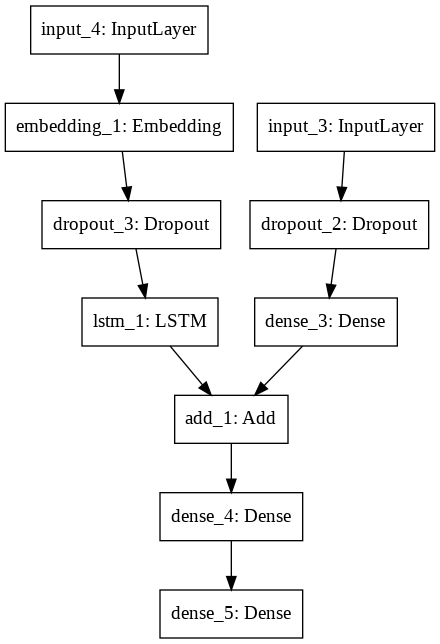

In [52]:
from keras.utils.vis_utils import plot_model
plot_model(model)

To generate a question, we iteratively predict the next character until we reach the maximum recursion_depth or we encounter the special token that indicates the end of a question


In [53]:
def generate(sentence:str) -> str:
    generated_question = start_token
    for _ in range(recursion_depth):
        generated_question += _predict_next_character(
            meaning=sentence,
            contextual_characters=generated_question,
        )
        if stop_token in generated_question:
            break
    return generated_question


Whereby to predict the next character in the sequence, we input the semantic vector of the utterance and the generated sequence of characters so far as inputs into our trained LSTM.  

In [55]:
def _predict_next_character(meaning:str,contextual_characters:str) -> str:
  X_meaning = array([_get_semantic_vector(meaning)])
  X_characters = array([_pad(_convert_characters_to_index(contextual_characters))])
  output_vector = model.predict((X_meaning,X_characters),verbose=False)
  predicted_index = _greedy_decode(output_vector)
  return index_character_mapping.get(predicted_index)
    

Note that while the input utterance semantics are represented by a fixed-length vector (the output of the pre-trained encoder) the input sequence generated so far must also be converted into a fixed-length vector (achieved by padding the sequence with 0s if it is shorter than the full sequence length - which is the maximum recursion_depth)

In [57]:
from keras.preprocessing.sequence import pad_sequences

def _pad(indexes:List[int]) -> array:
    return pad_sequences([indexes], maxlen=recursion_depth)[0]


In [58]:
_pad([1,2,3])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3], dtype=int32)

Also note that the model expects the character indexes (as opposed to the characters as strings) and also outputs character indexes as predictions.  Therefore, we need to dictionaries to map characters into indexes (`character_index_mapping`) and indexes back into characters again (`index_character_mapping`).

In [60]:
index_character_mapping = dict(enumerate(character_set))

character_index_mapping = {
    character:index for index,character in index_character_mapping.items()
}

def _convert_characters_to_index(characters:str) -> List[int]:
    return list(map(character_index_mapping.get,characters))

In [61]:
_convert_characters_to_index("example")

[5, 24, 1, 13, 16, 12, 5]


**Decoding Strategies**:

One of the most important factors about NLG (if not The Most Important) is the decoding strategy.  It is a hot topic of research!

>"Neural probabilistic text generators are far from
perfect; prior work has shown that they often generate text that is generic, unnatural and sometimes even non-existent". 

The model's outputs actually predict something akin to a probability distribution across the k possible output characters.  A `greedy` decoding strategy would simply take whichever index has the largest value (`argmax`) 

In [63]:
def _greedy_decode(predicted_vector:array) -> int:
    return predicted_vector[0].argmax()


In [69]:
y_hat = array([[.005, .124, .1, .13, .16, .12, .05]])
_greedy_decode(y_hat)

4

In [70]:
_predict_next_character("this is an example", "|")

'k'

In [71]:
generate("this is an example")

'|kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk'

However, this will not yield the best results in the long-run.  Even thought we greedily select the next most likely character (the `local optimum`) it does not mean this character leads to a sequence of characters which have the highest probability overall (the `global optimum`). 

For example, the token "park" may have a higher probability (.36) than the token "grocery" (.15), but only when you pick "grocery" can you have the sequence "grocery store" which has an overall higher probability score (.135) than any sequence that could be created with the token "park" (e.g. "park today" has a lower probability of .12)

A simple alternative, then, is to sample from the entire output according to their probabilities (so that the characters with higher probabilities are more likely to be selected) but still allowing the chance for less likely characters to be selected too.  While this random sampling strategy works better than the greedy strategy (which actually only produces a sequence of " " characters in both examples below), it can lead to some fairly noisy results.

Therefore we can introduce a constant called `temperature` to multiply with the probabilities as a way to increase the probability of picking the more likely characters and decrease the probability of picking the least likely characters (which are the source of the noise).  


In [72]:
from numpy.random import choice

def _temperature_decode(predicted_vector:array,temperature:float) -> int:
    probabilities = predicted_vector[0]
    probabilities *= temperature
    probabilities /= probabilities.sum()
    return choice(range(probabilities.size),1,p=probabilities)[0]


In [73]:
temperature = .5
_temperature_decode(y_hat,temperature)

4

In [76]:
_temperature_decode(y_hat,temperature)

1

In [77]:
_temperature_decode(y_hat,temperature)

2

In [109]:
def _predict_next_character(meaning:str,contextual_characters:str) -> str:
  X_meaning = array([_get_semantic_vector(meaning)])
  X_characters = array([_pad(_convert_characters_to_index(contextual_characters))])
  output_vector = model.predict((X_meaning,X_characters),verbose=False)
  predicted_index = _temperature_decode(output_vector,.5)
  return index_character_mapping.get(predicted_index)
    

In [110]:
generate("this is an example")

'|  dyse ien   iddrt   r rc t n pdp  y psip ooc p cpii    rrtrtit tilt?'

This produces better generated sequences of characters than greedy with far less noise than pure random sampling

Perhaps one-step better than this is `nucleus sampling` (p-decoding) wherein only the indexes which make up the top_p % of the probability distribution are sampled from. 


In [74]:
def _nucleus_decode(predicted_vector:array, top_p:float, temperature:Optional[float]) -> int:
    probabilities = predicted_vector[0]
    probabilities /= probabilities.sum()
    ranked_indexes = sorted(range(probabilities.size), key=lambda index:probabilities[index],reverse=True)
    probabilities.sort()
    ranked_probabilities = probabilities[::-1]
    for index in range(ranked_probabilities.size):
        if ranked_probabilities[:index].sum() >= top_p:
            nuclues_probabilities = ranked_probabilities[:index]
            nuclues_indexes = ranked_indexes[:index]
            break
    if temperature: nuclues_probabilities *= temperature
    nuclues_probabilities /= nuclues_probabilities.sum()
    return choice(nuclues_indexes,1,p=nuclues_probabilities)[0]

In [75]:
top_p = .8
_nucleus_decode(y_hat, top_p, temperature)

4

In [78]:
_nucleus_decode(y_hat, top_p, temperature)

3

In [79]:
_nucleus_decode(y_hat, top_p, temperature)

4

In [111]:
def _predict_next_character(meaning:str,contextual_characters:str) -> str:
  X_meaning = array([_get_semantic_vector(meaning)])
  X_characters = array([_pad(_convert_characters_to_index(contextual_characters))])
  output_vector = model.predict((X_meaning,X_characters),verbose=False)
  predicted_index = _nucleus_decode(output_vector,.8, .5)
  return index_character_mapping.get(predicted_index)

In [112]:
generate("this is an example")

'|  ann enid e  nedteirnsr  pninppppcp pc pciiei is ktticitt?'

Nucleus sampling produces slightly higher quality text as compared with temperature sampling.  However, we can also include temperature with nucleus sampling to improve it even further: 


However, for near optimal results, it has become the industry standard to use `beam search` (maintaining the top-k generated sequences).  However, maintaining multiple sequences (even if constrained to k beams) is much more computationally expensive than keeping track of a single sequence (as the above strategies do).  Is there any way to arrive at a near-optimal sequence without having to maintain multiple sequences (as with beam search)?  

Beam search, however, is somewhat of an enigma.  It somehow manages to generate near-optimal sequences with only a small number of beams.  What is more mysterious, however, is the the phenomena known as the `beam search curse` 

> "a specific phenomenon where using a larger beam
size leads to worse performance"

In fact, "the success of beam search does not stem from its ability to approximate exact decoding in practice, but rather due to a hidden inductive bias embedded in the algorithm. This inductive bias appears to be paramount for generating desirable text". This [paper](https://aclanthology.org/2020.emnlp-main.170.pdf) analyses exactly how beam search is biasing generated sequences, in the hope that understanding this will allow for a more direct way to replicate the success of a beam search. The authors conclude that: 

> "We provide a plausible answer—inspired by psycholinguistic theory—as to why beam search (with small beams) leads to high-quality text" 

>"beam search enforces uniform information density in text"

>"beam search is trying to optimize for UID"

>"beam search has an inductive bias which can be linked to the promotion of uniform information density (UID), a theory from cognitive science regarding even distribution of information in linguistic signals"
>> "The UID hypothesis states that—subject to the constraints of the grammar—humans prefer sentences that distribute information (in the sense of information theory) equally across the linguistic signal, e.g., a sentence. In other words, human-produced text, regardless of language, tends to have evenly distributed surprisal, formally defined in information theory as negative log-probability"

They then suggest "a battery of possible sentence-level UID measures" as candidate "decoding objectives that explicitly enforce this property" to replicate the success of beam search (note the above example depicting one such objective on a single sequence which generates the exact same sequence as generated by a k=5 beam search)

>"This insight naturally leads to the development of several new regularizers that likewise enforce the UID property"


**Training**:

Training the model is as simple as fitting it to the formatted question data (We also save the model weights after each epoch so that we can load in the trained model later)

In [102]:
def train(
    questions:List[str], 
    batch_size:int, epochs:int, 
    save_to_file_path:str="char_lstm_weights.hdf5",
) -> None:
    steps_per_epoch = len(questions)//batch_size
    for epoch in range(epochs):
        model.fit(
            _get_training_data(questions, batch_size), 
            verbose=True, epochs=1, steps_per_epoch=steps_per_epoch, 
        )
        model.save_weights(save_to_file_path)

To format the training data, we create a generator to iterate through the questions and get its semantics, then we convert the characters into indexes and iterate through them one by one, making each an expected character output (encoded as a one-hot vector) with the preceding characters the training inputs (padded to ensure consistent sequence lengths).  

In [83]:
from tensorflow.keras.utils import to_categorical
def _one_hot_encode_output(index:int) -> array:
    return to_categorical([index], num_classes=number_of_characters)[0]

In [84]:
_one_hot_encode_output(4)

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

When a batch has been reached, the semantic vectors (`X_meaning`) and the input character sequences (`X_characters`) are yielded along with the expected character outputs (`Y_characters`)


In [85]:
def _get_training_data(questions:List[str],batch_size:int) -> Tuple[Tuple[array,array],array]:
    iteration_count,X_meaning, X_characters, Y_characters = 0,[],[],[]
    while True:
        for question in questions:
            iteration_count+=1

            semantic_vector = _get_semantic_vector(question)
            processed_question = _preprocess_characters(question)
            character_indexes = _convert_characters_to_index(processed_question)
            for index in range(1, len(character_indexes)):
                contextual_character_indexes = character_indexes[:index]
                next_character_index = character_indexes[index]                    
                X_meaning.append(semantic_vector)
                X_characters.append(_pad(indexes=contextual_character_indexes))
                Y_characters.append(_one_hot_encode_output(next_character_index))

            if iteration_count==batch_size:
                yield ([array(X_meaning), array(X_characters)],array(Y_characters))
                iteration_count,X_meaning, X_characters, Y_characters = 0,[],[],[]

In [93]:
clean_string = lambda text:''.join(filter(is_valid_character,text.lower().strip()))
is_valid_character = lambda character: character.isspace() or a <= ord(character) <= z

def _preprocess_characters(text:str) -> str:
    return f"{start_token} {clean_string(text)} {stop_token}"


**Dataset**:

Now we can train our decoder model, we just need a dataset of unlabelled questions.  We can pick one of the many datasets which contain questions, such as the `Quora` question pairs dataset. 

The dataset is publically available and can be downloaded from [here](https://raw.githubusercontent.com/MLDroid/quora_duplicate_challenge/master/data/quora_duplicate_questions.tsv)

Since we dont require labelled questions, we will just extract all the unique questions in the dataset and ignore any labels they provide.

In [95]:
!wget https://raw.githubusercontent.com/MLDroid/quora_duplicate_challenge/master/data/quora_duplicate_questions.tsv

--2021-09-13 01:15:29--  https://raw.githubusercontent.com/MLDroid/quora_duplicate_challenge/master/data/quora_duplicate_questions.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58176133 (55M) [text/plain]
Saving to: ‘quora_duplicate_questions.tsv’

quora_duplicate_que 100%[===================>]  55.48M   159MB/s    in 0.3s    

2021-09-13 01:15:30 (159 MB/s) - ‘quora_duplicate_questions.tsv’ saved [58176133/58176133]



In [96]:
from pandas import read_csv

def load_quora_data(path_to_file:str) -> List[str]:
    quora_dataset = read_csv(path_to_file, sep='\t', header=0)
    questions = quora_dataset.question1.append(quora_dataset.question2)
    questions = questions.apply(str)
    return sorted(set(questions))

In [105]:
first_ten_questions_only = load_quora_data("quora_duplicate_questions.tsv")[:10]
first_ten_questions_only

[' Any Canadian teachers (B.Ed. holders) teaching in U.S. schools?',
 ' Are there any underlying psychological tricks/tactics that are used when designing the lines for rides at amusement parks?',
 ' Can I pay with a debit card on PayPal?',
 ' Does New York state have a flagship university?',
 ' Failures haunt me all the time.How do I cope up?',
 ' How can I improve my sex life?',
 ' How do I make the time lapse images using an EOS 70D, with an intervalometer?',
 ' How will you interpret my dream?',
 " I am a 5 letter word.  I am normally below u  If u remove my 1st letter   u'll find me above u  If u remove my 1st & 2nd letters  u cant see me  Answer is really very interesting  Let us see who solves this.... ⏰Time limit :- today U can also send to other grps if I?",
 " I didn't file a police report for a car accident that happened over a month ago. My insurance company won't pay for damage, what do I do?"]

In [106]:
train(first_ten_questions_only,batch_size=6,epochs=5,save_to_file_path="lstm_quora.hdf5") 


1/1 [==============================] - 1s 630ms/step - loss: 1.9355


In [107]:
!ls

lstm_quora.hdf5  model.png  quora_duplicate_questions.tsv  sample_data


In [113]:
generate("this is an example")

'|yi r   e     i  nn e innnen  ne   st cn ippplplag cc  pcepnpitkttctc?'

**Pros**:

- Only requires unlabelled data to train (unsupervised learning)

- Since the utterances are vectorised into a fixed-length semantic vector, the input length is not a problem (it can be any length - be it an entire conversation or a single word)!

- since we are only training a decoder, it is far lighter than learning an entire encoder-decoder model 

- Since the decoder is a character-level LSTM, it has a very small output size (as the vocabulary consists of just the alphabet)

- The model is able to generate more creative, natural sounding questions (which need not start with typical "Wh"-question words)

**Cons**:

- The encoder is very simple and a far superior semantic representation can be achieved if this is replaced

- The decoder could be trained in less iterations and produce more exressive questions still if we were to fine-tune a pre-trained generative language model

- The decoding strategy is currently temperature sampling and could be improved using nucleus-sampling, beam-search or one of the suggested uid measures


# 4. Semantic-Image Captioning Character-based LSTM (Supervised Learning)


Although the model described above can be trained on unlabelled questions, it can also be trained on labelled data in a more typical supervised fashion, if such data is available! When training the model, we would just use the semantics of the utterances (instead of the question) and everything else remains the same as before.

This method can, in theory, produce a better trained model than the unsupervised version simply because you can train it to respond with questions that have very different semantics than the input utterances (to steer the conversation into a new direction or add a bit more novelty). 

It so happens that for this task, there is an abundance of datasets to map utterances to questions!  Its just that we need to be a bit creative in how we view these datasets.  For instance, every single question-answer dataset (e.g. `SQUAD2.0`, `Google Natural Questions`, etc) is mapping a question to an answer.  So if we reverse the order, we get a dataset that maps answers (or utterances) onto questions! Et Voila!

Lets show how this is done with SQUAD2.0 which we can download from [here](https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json)

The SQUAD dataset comes as a json with the following keys: 


In [116]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json

--2021-09-13 01:25:42--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   140MB/s    in 0.3s    

2021-09-13 01:25:43 (140 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]



In [114]:
from enum import Enum

class SquadDataKeys(Enum):
    DATA = "data"
    TITLE = "title"
    PARAGRAPH = "paragraphs"
    CONTEXT = "context"
    QUESTIONANSWER = "qas"
    QUESTION = "question"

We can load in the json and iterate through it to extract the titles (as our short utterances) and the contexts (as our long utterances) and the questions that go with them:


In [115]:
from json import loads

def load_squad_data(path_to_file:str) -> List[Tuple[str,str]]:
    with open(path_to_file) as json_file:
        squad2_data = loads(json_file.read())
        for topic_data in squad2_data[SquadDataKeys.DATA.value]:
            short_context = topic_data[SquadDataKeys.TITLE.value]
            for paragraph in topic_data[SquadDataKeys.PARAGRAPH.value]:
                long_context = paragraph[SquadDataKeys.CONTEXT.value]
                for index,question_data in enumerate(paragraph[SquadDataKeys.QUESTIONANSWER.value]):
                    question = question_data[SquadDataKeys.QUESTION.value]
                    if index == 0: yield (short_context, question)
                    yield (long_context, question)

In [117]:
contexts,questions = zip(*load_squad_data("train-v2.0.json"))


In [125]:
contexts[:4]

('Beyoncé',
 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 199

In [124]:
questions[:4]


('When did Beyonce start becoming popular?',
 'When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?")

It also happens we have an even better dataset which was actually designed to provides utterances and then questions (well actually it was designed to simulate realistic conversations, but it so happens to have questions within the conversations).  This dataset is `DailyDialog` which we can download from [here](https://aclanthology.org/attachments/I17-1099.Datasets.zip)

This dataset also provides dialogue_act labels which we can use to identify the questions automatically and extract them along with the the utterances that precede it to form our training data:

In [128]:
!wget https://aclanthology.org/attachments/I17-1099.Datasets.zip

--2021-09-13 01:30:06--  https://aclanthology.org/attachments/I17-1099.Datasets.zip
Resolving aclanthology.org (aclanthology.org)... 174.138.37.75
Connecting to aclanthology.org (aclanthology.org)|174.138.37.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4751210 (4.5M) [application/zip]
Saving to: ‘I17-1099.Datasets.zip’

I17-1099.Datasets.z 100%[===================>]   4.53M  18.7MB/s    in 0.2s    

2021-09-13 01:30:06 (18.7 MB/s) - ‘I17-1099.Datasets.zip’ saved [4751210/4751210]



In [129]:
!ls

I17-1099.Datasets.zip  model.png		      sample_data
lstm_quora.hdf5        quora_duplicate_questions.tsv  train-v2.0.json


In [130]:
!sudo apt-get install unzip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [131]:
!unzip I17-1099.Datasets.zip

Archive:  I17-1099.Datasets.zip
   creating: EMNLP_dataset/
  inflating: EMNLP_dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/EMNLP_dataset/
  inflating: __MACOSX/EMNLP_dataset/._.DS_Store  
  inflating: EMNLP_dataset/dialogues_act.txt  
  inflating: EMNLP_dataset/dialogues_emotion.txt  
  inflating: EMNLP_dataset/dialogues_text.txt  
  inflating: EMNLP_dataset/dialogues_topic.txt  
  inflating: EMNLP_dataset/readme.txt  
  inflating: __MACOSX/EMNLP_dataset/._readme.txt  
  inflating: EMNLP_dataset/test.zip  
  inflating: EMNLP_dataset/train.zip  
  inflating: EMNLP_dataset/validation.zip  


In [132]:
!ls

EMNLP_dataset	       __MACOSX			      sample_data
I17-1099.Datasets.zip  model.png		      train-v2.0.json
lstm_quora.hdf5        quora_duplicate_questions.tsv


In [126]:
def load_daily_dialog(path_to_file:str) -> List[Tuple[str,str]]:
    with open(f"{path_to_file}/{DailyDialogKeys.ACT_FILENAME.value}") as dialogue_act_file:
        dialogue_acts = dialogue_act_file.readlines()

    with open(f"{path_to_file}/{DailyDialogKeys.DIALOGUE_FILENAME.value}") as dialogue_file:
        dialogues = dialogue_file.readlines()

    for line_dialogue,line_acts in zip(dialogues,dialogue_acts):
        question_in_dialogue = DailyDialogKeys.QUESTION_ACT.value in line_acts[1:]
        if question_in_dialogue:
            utterances = line_dialogue.split(DailyDialogKeys.END_OF_UTTERANCE.value)[:-1]
            question_act_indexes = [
                position for position, act_index in enumerate(line_acts.strip().split()) \
                if position > 0 and act_index == DailyDialogKeys.QUESTION_ACT.value
            ]
            for question_index in question_act_indexes:
                question = utterances[question_index]
                context = utterances[:question_index]
                yield (' '.join(context),question)

class DailyDialogKeys(Enum):
    QUESTION_ACT = "2"
    END_OF_UTTERANCE = "__eou__"
    ACT_FILENAME = "dialogues_act.txt"
    DIALOGUE_FILENAME = "dialogues_text.txt"

In [134]:
contexts,questions = zip(*load_daily_dialog("EMNLP_dataset"))

In [135]:
contexts[:3]

('Would you mind waiting a while ? ',
 'Isn ’ t he the best instructor ? I think he ’ s so hot . Wow ! I really feel energized , don ’ t you ?   I swear , I ’ m going to kill you for this . ',
 'Can I take your order now or do you still want to look at the menu ? ')

In [136]:
questions[:3]

(' Well , how long will it be ? ',
 ' What ’ s wrong ? Didn ’ t you think it was fun ? ! ',
 " Well , I want a fillet steak , medium , but my little girl doesn't care for steak . Could she have something else instead ? ")

I've included the trained model weights `lstm_dailydialog.hdf5` on my repo so that the model can be loaded and played around with (using `python interact_lstm.py` )  Enjoy!
